In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# %matplotlib widget


In [2]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from collections import OrderedDict
from itertools import product
from itertools import groupby
import itertools
import pickle
import glob
import chardet
import copy
from natsort import natsorted

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
# Set a professional style for the plot
plt.style.use('ggplot')
import matplotlib.dates as mdaates
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace, Stream
from obspy.imaging.spectrogram import spectrogram
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
from scipy.stats import norm, kstest, skew, kurtosis
import warnings
warnings.filterwarnings("ignore")

# Local Imports
from energy.utils_general import *
from energy.utils_energy import *
from energy.preprocessing import *
from energy.metrics import *
from picking.p_picking import p_picking_each

A tener en consideración. Las rutas a los archivos están guardadas de la siguiente forma: *waveform_M/event_ID/channel/station/eventid_canal_horainicio_horatermino.mseed*


# 1. Creamos un diccionario con las coordenadas de las estaciones del litoral a partir del archivo Excel.

In [3]:
v_P = 8.064

file_stations_coord = os.path.join("BD paper", "catalogos","Estaciones_Chile.csv")
df = pd.read_csv(file_stations_coord, sep=';')
stations_coord_all = df.set_index('Station')[['Latitude', 'Longitude']].apply(tuple, axis=1).to_dict()
stations_names = list(stations_coord_all.keys())

# 2. Trabajar con la base de datos

### 2.1. La función z_channel_dict entrega un nested dictionary donde la primera capa de llaves indica la magnitud, la segunda capa el evento, la tercera la red de la estación que la captó, y finalmente el valor es la traza ya leída por obspy

In [4]:
# Get the path to all the folders from the folder BD paper that is in the current directory
#folders = glob.glob('BD paper/*')
folders = glob.glob(os.path.join('BD paper', '*'))
# Get all the folders in the BD paper folder that start with waveform 
#folders_signals = [folder for folder in folders if folder.startswith('BD paper/waveform')]
folders_signals = [folder for folder in folders if folder.startswith(os.path.join('BD paper', 'waveform'))]

folders_signals = sorted(folders_signals)

In [5]:
folders_signals

['BD paper\\waveform_1-2.9',
 'BD paper\\waveform_3p1',
 'BD paper\\waveform_3p2',
 'BD paper\\waveform_4p1',
 'BD paper\\waveform_4p2',
 'BD paper\\waveform_5',
 'BD paper\\waveform_6-9']

Esta función se puede/debe optimizar. Usando os.walk probablemente sale más rápido. No sé si existe alguna forma de hacerla más generalizable eso si

In [6]:
inventory_path = "inventory"
#inventory_path = os.path.join('BD paper', 'stations_xml')
def z_channel_dict(folders_signals, inventory_path=inventory_path):

    result_dict_z = OrderedDict()
    #result_dict_e = OrderedDict()
    #result_dict_n = OrderedDict()


    for folder in folders_signals:
        waveform_type = os.path.split(folder)[-1]
        events_id = natsorted(glob.glob(os.path.join(folder, '*')))

        for event_id in events_id:
            events_name = os.path.split(event_id)[-1]
            network_path = glob.glob(os.path.join(event_id, '*'))

            for network_folder in network_path:
                network_name = os.path.split(network_folder)[-1]
                
                stations_path = glob.glob(os.path.join(network_folder, '*'))

                for station_path in stations_path:
                    stations_names = os.path.split(station_path)[-1]
                    #ic(stations_names)
                    stations_path = glob.glob(os.path.join(station_path, '*'))
                    #ic(stations_path)

                    stations_ch_z = [station_z for station_z in stations_path if 'BHZ' in station_z]
                    stations_ch_e = [station_e for station_e in stations_path if 'BHE' in station_e]
                    stations_ch_n = [station_n for station_n in stations_path if 'BHN' in station_n]
                    
                    traces = []

                    #ic(len(stations_ch_z))
                    # Read and store traces using ObsPy
                    # traces_z = []

                    # Files to remove response
                    file_response = glob.glob(os.path.join(inventory_path, f"*{stations_names}.xml"))
                    # #ic(file_response)


                    # trace_z = read(stations_ch_z[0])[0]  # Assuming one trace per file
                    
                    if file_response:
                        remove_file_z = file_response[0]

                    # #ic(remove_file_z)
                    # trace_resp_z = trace_z.copy()
                    # trace_removed_z = remove_response(trace_resp_z, remove_file_z , 'obspy')
                    # #st_resp[2] = st_removed
                    # st_z = trace_removed_z.copy()
                    # st_z.filter('bandpass', freqmin=4.0, freqmax=10.0)
                    
                    # traces_z.append(st_z)



                    trace_Z = read(stations_ch_z[0])[0]
                    trace_resp = trace_Z.copy()
                    trace_resp = remove_response(trace_resp, remove_file_z , 'obspy')
                    trace = Stream(traces = trace_resp)
                    if len(stations_ch_e) > 0:
                        trace += read(stations_ch_e[0])[0]
                    if len(stations_ch_n) > 0:    
                        trace += read(stations_ch_n[0])[0]
                    

                    # if file_response:
                    #     remove_file = file_response[0]

                    # ic(remove_file)

                    # tr_resp = trace.copy()
                    # for i in range(len(trace)):
                    #     st_removed = remove_response(tr_resp.select(channel=tr_resp[i].stats.channel)[0], remove_file , 'obspy')
                    #     tr_resp[i] = st_removed
                    #     ic(i)

                    tr_filtered = trace.copy()
                    tr_filtered.filter('bandpass', freqmin=4.0, freqmax=10.0)
                    traces.append(tr_filtered)

                    result_dict_z.setdefault(waveform_type, {}).setdefault(events_name, {}).setdefault(network_name, {}).setdefault(stations_names, traces)


    return result_dict_z

event_dict = z_channel_dict(folders_signals)


In [ ]:
#inventory_path = "inventory"
inventory_path = os.path.join('BD paper', 'stations_xml')
def all_channels_dict(folders_signals, inventory_path=inventory_path):

    result_dict = OrderedDict()

    for folder in folders_signals:
        waveform_type = os.path.split(folder)[-1]
        events_id = natsorted(glob.glob(os.path.join(folder, '*')))

        for event_id in events_id:
            events_name = os.path.split(event_id)[-1]
            network_path = glob.glob(os.path.join(event_id, '*'))

            for network_folder in network_path:
                network_name = os.path.split(network_folder)[-1]
                
                stations_path = glob.glob(os.path.join(network_folder, '*'))

                for station_path in stations_path:
                    stations_names = os.path.split(station_path)[-1]
                    #ic(stations_names)
                    stations_path = glob.glob(os.path.join(station_path, '*'))
                    #ic(stations_path)

                    stations_ch_z = [station_z for station_z in stations_path if 'BHZ' in station_z]
                    stations_ch_e = [station_e for station_e in stations_path if 'BHE' in station_e]
                    stations_ch_n = [station_n for station_n in stations_path if 'BHN' in station_n]
                    
                    traces = []


                    # Files to remove response
                    file_response = glob.glob(os.path.join(inventory_path, f"{stations_names}.xml"))
                    

                    if file_response:
                        remove_file = file_response[0]
                    trace = read(stations_ch_z[0])

                    if len(stations_ch_e) > 0:
                        trace += read(stations_ch_e[0])
                    if len(stations_ch_n) > 0:
                        trace += read(stations_ch_n[0])
                    tr_resp = trace.copy()
                    for i in range(len(trace)):
                        st_removed = remove_response(tr_resp.select(channel=tr_resp[i].stats.channel)[0], remove_file , 'obspy')
                        tr_resp[i] = st_removed


                    tr_filtered = tr_resp.copy()
                    tr_filtered.filter('bandpass', freqmin=4.0, freqmax=10.0)
                    traces.append(tr_filtered)

                    result_dict.setdefault(waveform_type, {}).setdefault(events_name, {}).setdefault(network_name, {}).setdefault(stations_names, traces)


    return result_dict

event_dict = all_channels_dict(folders_signals)

In [7]:
waveform_type = list(event_dict.keys())

# get all the events ids consideting waveform type is a list. And make events_ids a dictionary with the waveform type as keys
events_ids = {waveform_type: [int(event_id) for event_id in event_dict[waveform_type].keys()] for waveform_type in waveform_type}


### 2.2. La siguiente función pone a todas las traces de TODOS los eventos en una fila, esto lo tengo a priori, quizás habrá que arreglarlo

In [8]:
def get_all_traces(nested_dict):
    traces = []
    for value in nested_dict.values():
        if isinstance(value, dict):
            traces.extend(get_all_traces(value))
        else:
            traces.extend(value)
    return traces

# Get all ObsPy Trace objects in the dictionary
all_traces = get_all_traces(event_dict)

### 2.3 El siguiente código es para crear un nuevo archivo CSV que contenga solo los siguientes datos:
- EventId
- Time
- Latitud
- Longitud
- Magnitud
- Estación (la que aparece automáticamente en el catálogo)
- Estaciones más cercanas (calculada con geodisic. Cantidad arbitraria)

In [ ]:
# FUNCION QUE USABA ANTES CUANDO TRABAJA CON CARPETA LISTA DE EVENTOS. PODRÍA SERVIR EN UN FUTURO

'''
def merge_coordinates(files_to_add, files_with_coord):
    
    for file_to_add, file_with_coords in zip(files_to_add, files_with_coord):
        df_to_add = pd.read_csv(file_to_add, sep=',')
        df_with_coords = pd.read_csv(file_with_coords, sep='|')

        df_to_add['Time'] = pd.to_datetime(df_to_add['Time'])
        df_with_coords['Time'] = pd.to_datetime(df_with_coords['Time'])

        df_to_add = df_to_add.set_index('Time')

        # Merge df_to_add with df_with_coords on 'Time', keeping only 'Latitude' and 'Longitude' from df_with_coords
        df_to_add = pd.merge(df_to_add, df_with_coords[['Time','Latitude', 'Longitude']], on='Time', how='left', suffixes=('', '_y'))

        # Drop the '_y' columnsbb
        df_to_add = df_to_add.drop(columns=['Latitude_y', 'Longitude_y'], errors='ignore')

        df_to_add.to_csv(file_to_add, index=False, sep = ',')


# Get all the csv files in the BD paper folder that have the word "cercanos" in their name
files_raw = sorted(glob.glob(os.path.join('BD paper', 'catalogos','*cercanos*.csv')))
# Get all the csv files in the BD paper folder that have the word "full_data" in their name
files_full_data = sorted(glob.glob(os.path.join('BD paper', 'lista de datos','*full_data*.csv')))


# Call the function to merge coordinates for each pair of files
merge_coordinates(files_raw, files_full_data)

'''

In [9]:
# Get all the csv files in the BD paper folder that have the word "cercanos" in their name
files_raw = sorted(glob.glob(os.path.join('BD paper', 'catalogos','*descargados*.csv')))

files_raw

['BD paper\\catalogos\\Eventos_descargados_1-2.9.csv',
 'BD paper\\catalogos\\Eventos_descargados_3p1.csv',
 'BD paper\\catalogos\\Eventos_descargados_3p2.csv',
 'BD paper\\catalogos\\Eventos_descargados_4p1.csv',
 'BD paper\\catalogos\\Eventos_descargados_4p2.csv',
 'BD paper\\catalogos\\Eventos_descargados_5.csv',
 'BD paper\\catalogos\\Eventos_descargados_6-9.csv']

In [10]:
def filter_csv(files_raw, events_ids):
    # Columnas a mantener
    columns_to_keep = ["#EventID", "Time", "Latitude", "Longitude", "Magnitude", "Estacion"]

    for i, (waveform_type, event_ids) in enumerate(events_ids.items()):
        # Leer el archivo CSV
        df = pd.read_csv(files_raw[i], sep=';')

        # Filtrar las filas donde '#EventID' está en event_ids
        df = df[df['#EventID'].isin(event_ids)]

        # Ordernar la columna de #EventID
        df = df.sort_values(by='#EventID')

        # Mantener solo las columnas deseadas
        df = df[columns_to_keep]

        # Guardar el nuevo DataFrame en un nuevo archivo CSV
        df.to_excel(os.path.join("BD paper", "catalogos", f"{waveform_type}_filtered.xlsx"), index=False)

filter_csv(files_raw, events_ids)


### 2.4. Ahora que ya se tienen archivos .csv con columnas "Event"Time", "Magnitud", "Estación", "Latitud", "Longitud", podemos verificar efectivamente cuál es la estación más cercana y agregarla como última columna

In [11]:
files_filtered = sorted(glob.glob(os.path.join('BD paper', 'catalogos','*filtered*')))
files_filtered

['BD paper\\catalogos\\waveform_1-2.9_filtered.xlsx',
 'BD paper\\catalogos\\waveform_3p1_filtered.xlsx',
 'BD paper\\catalogos\\waveform_3p2_filtered.xlsx',
 'BD paper\\catalogos\\waveform_4p1_filtered.xlsx',
 'BD paper\\catalogos\\waveform_4p2_filtered.xlsx',
 'BD paper\\catalogos\\waveform_5_filtered.xlsx',
 'BD paper\\catalogos\\waveform_6-9_filtered.xlsx']

Esta función además agrega columnas con el tiempo estimado donde el sismo debería verse en la i-ésima estación más cercana.

In [12]:
def closest_station(file_path, stations_coord_all, v_P, n_closest_stations = 7):
    '''
    Actualiza todos los archivos csv con la estación más cercana a cada evento sísmico.
    '''

    for file in file_path:
        ic(file)

        df_events = pd.read_excel(file)

        # Cambiar nombre de la columna "Time" a "Fecha UTC" y cosas en inglés por español
        df_events = df_events.rename(columns={'Time': 'Fecha UTC', 'Latitude': 'Latitud', 'Longitude': 'Longitud', 'Magnitude': 'Magnitud'})
        
        # Cambiar esta columna a formato UTC
        df_events['Fecha UTC'] = pd.to_datetime(df_events['Fecha UTC'])
        #df_events = df_events.rename(columns={'Latitude': 'Latitud', 'Longitude': 'Longitud'})

        df_events.to_excel(file, index=False)

        # Tomar el valor máximo y mínimo de la magnitud en el dataframe
        max_magnitude = df_events['Magnitud'].max()
        min_magnitude = df_events['Magnitud'].min()

        df_new = calculate_detection_times(df_events, stations_coord_all, v_P, magnitude_range=(min_magnitude, max_magnitude))
        _, closest_sts_names = nearest_n_stations(df_new, stations_names, n_closest_stations)

        df_events = pd.read_excel(file)

        # Agregar columnas para cada estación cercana
        for i in range(n_closest_stations):
            col_name = f'Estación más cercana {i+1}'
            df_events[col_name] = closest_sts_names[i]

        df_events.to_excel(file, index=False)

        df_events = pd.read_excel(file)

        # Agregar columnas para el tiempo de inicio de cada estación cercana
        for i in range(n_closest_stations):
            col_name = f'Inicio estación más cercana {i+1}'
            df_events[col_name] = df_events.apply(lambda row: df_new.loc[row.name, f'Inicio_{row[f"Estación más cercana {i+1}"]}'], axis=1)

        # Escribir en el archivo excel
        df_events.to_excel(file, index=False)


closest_station(files_filtered, stations_coord_all, v_P)


ic| file: 'BD paper\\catalogos\\waveform_1-2.9_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_3p1_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_3p2_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_4p1_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_4p2_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_5_filtered.xlsx'
ic| file: 'BD paper\\catalogos\\waveform_6-9_filtered.xlsx'


# 3. Procesamiento de las trazas
Ahora que ya tenemos los archivos excel con las estaciones más cercanas y con sus estimados tiempos de detección del evento, podemos empezar a trabajar con las trazas

## 3.1. Calculo de la potencia
Se deben juntar todas las trazas que pertenecen a cada intervalo de magnitud en una sola lista para luego calcular la potencia. Es decir, todas las que son entre 4 y 5, todas las que son entre 5 y 6, y todas las que son mayores que 6. 

In [15]:

'''
def find_matching_trace(event_dict, dataframe, waveform_key, station_columns = list_closest_stations):
    trace_list = []
    event_dict_waveform = event_dict[waveform_key]
    #ic(event_dict_waveform)

    for i in range(len(dataframe['#EventID'].astype(str))):
        channels = list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].keys())
        #station_data = list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].values())
        #station_names = [key for station_dict in station_data for key in station_dict.keys()]

        station_data = {key: value for sublist in list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].values()) for key, value in sublist.items()}
        #ic(station_data)
        station_names = list(station_data.keys())
    

        for column in dataframe.loc[:, station_columns]:
            station_column_value = dataframe[column].astype(str).iloc[i]

            matching_station = next((station for station in station_names if station in station_column_value), None)

            if matching_station is not None:
                #trace_list.append(station_data[0][matching_station])
                #ic(matching_station)
                #ic(station_data)
                #ic(station_data[matching_station][0])

                trace_list.extend(station_data[matching_station])
                break
            else:
                # Tu código si no hay ninguna coincidencia
                pass

    return trace_list


df_mag4p1 = pd.read_excel(files_filtered[0])
df_mag4p2 = pd.read_excel(files_filtered[1])
df_mag5 = pd.read_excel(files_filtered[2])
df_mag69 = pd.read_excel(files_filtered[3])


trace_mag4p1 = find_matching_trace(event_dict, df_mag4p1, waveform_type[0], list_closest_stations)
#trace_mag4p2 = find_matching_trace(event_dict, df_mag4p2, waveform_type[1], list_closest_stations)
#trace_mag5 = find_matching_trace(event_dict, df_mag5, waveform_type[2], list_closest_stations)
#trace_mag69 = find_matching_trace(event_dict, df_mag69, waveform_type[3], list_closest_stations)




# def find_matching_trace_v2(event_dict, dataframe, waveform_key, station_columns = list_closest_stations):
#     trace_list = []
#     event_dict_waveform = event_dict[waveform_key]

#     for i in range(len(dataframe['#EventID'].astype(str))):
#         #channels = list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].keys())
#         station_data = {key: value for sublist in list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].values()) for key, value in sublist.items()}
#         #ic(station_data)
#         station_names = list(station_data.keys())
        

#         for j, column in enumerate(dataframe.loc[:, station_columns]):
#             station_column_value = dataframe[column].astype(str).iloc[i]
#             matching_station = next((station for station in station_names if station in station_column_value), None)

#             if matching_station is not None:
#                 # Cambiar el tiempo de inicio de la traza
#                 start_time_column = f"Inicio estación más cercana {j+1}"
#                 start_time = UTCDateTime(dataframe[start_time_column].iloc[i])
#                 #ic(start_time)
                
#                 trace = station_data[matching_station][0]
#                 #ic(trace)
#                 trace[0].stats.starttime = start_time

#                 trace_list.extend(station_data[matching_station])
#                 break

#     return trace_list

'''


In [13]:
list_closest_stations = ['Estación más cercana 1', 'Estación más cercana 2', 'Estación más cercana 3', 'Estación más cercana 4', 'Estación más cercana 5', 'Estación más cercana 6', 'Estación más cercana 7']


def find_matching_trace_v2(event_dict, dataframe, waveform_key, station_columns=list_closest_stations):
    trace_dict = {}  # Cambié trace_list por trace_dict

    event_dict_waveform = event_dict[waveform_key]

    for i in range(len(dataframe['#EventID'].astype(str))):
        station_data = {key: value for sublist in
                        list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].values()) for key, value
                        in sublist.items()}
        station_names = list(station_data.keys())

        for j, column in enumerate(dataframe.loc[:, station_columns]):
            station_column_value = dataframe[column].astype(str).iloc[i]
            matching_station = next((station for station in station_names if station in station_column_value), None)

            if matching_station is not None:
                start_time_column = f"Inicio estación más cercana {j + 1}"
                start_time = UTCDateTime(dataframe[start_time_column].iloc[i])

                trace = station_data[matching_station][0]
                trace[0].stats.starttime = start_time

                # Cambiado trace_list por trace_dict
                if dataframe['#EventID'].iloc[i] not in trace_dict:
                    trace_dict[dataframe['#EventID'].iloc[i]] = []
                trace_dict[dataframe['#EventID'].iloc[i]].extend(station_data[matching_station])

                break

    return trace_dict

df_mag12 = pd.read_excel(files_filtered[0])
df_mag3p1 = pd.read_excel(files_filtered[1])
df_mag3p2 = pd.read_excel(files_filtered[2])
df_mag4p1 = pd.read_excel(files_filtered[3])
df_mag4p2 = pd.read_excel(files_filtered[4])
df_mag5 = pd.read_excel(files_filtered[5])
df_mag69 = pd.read_excel(files_filtered[6])

def create_traces(event_dict, dataframe, waveform_key, station_columns):
    trace_dict = find_matching_trace_v2(event_dict, dataframe, waveform_key, station_columns)
    trace_Z = {event_id: trace[0].select(channel='BHZ')[0] for event_id, trace in trace_dict.items()}
    trace_E = {event_id: trace[0].select(channel='BHE')[0] for event_id, trace in trace_dict.items()}
    trace_N = {event_id: trace[0].select(channel='BHN')[0] for event_id, trace in trace_dict.items()}
    return trace_Z, trace_E, trace_N


waveform_types = [waveform_type[i] for i in range(7)]
dataframes = [df_mag12, df_mag3p1, df_mag3p2, df_mag4p1, df_mag4p2, df_mag5, df_mag69]

traces = [create_traces(event_dict, df, waveform, list_closest_stations) for waveform, df in zip(waveform_types, dataframes)]

trace_mag12_v2_Z, trace_mag12_v2_E, trace_mag12_v2_N = traces[0]
trace_mag3p1_v2_Z, trace_mag3p1_v2_E, trace_mag3p1_v2_N = traces[1]
trace_mag3p2_v2_Z, trace_mag3p2_v2_E, trace_mag3p2_v2_N = traces[2]
trace_mag4p1_v2_Z, trace_mag4p1_v2_E, trace_mag4p1_v2_N = traces[3]
trace_mag4p2_v2_Z, trace_mag4p2_v2_E, trace_mag4p2_v2_N = traces[4]
trace_mag5_v2_Z, trace_mag5_v2_E, trace_mag5_v2_N = traces[5]
trace_mag69_v2_Z, trace_mag69_v2_E, trace_mag69_v2_N = traces[6]


In [14]:
# put trace_mag4p1 and trace_mag4p2 together in one list called trace_mag4
trace_mag3_v2_Z = {**trace_mag3p1_v2_Z, **trace_mag3p2_v2_Z}
trace_mag3_v2_E = {**trace_mag3p1_v2_E, **trace_mag3p2_v2_E}
trace_mag3_v2_N = {**trace_mag3p1_v2_N, **trace_mag3p2_v2_N}

trace_mag4_v2_Z = {**trace_mag4p1_v2_Z, **trace_mag4p2_v2_Z}
trace_mag4_v2_E = {**trace_mag4p1_v2_E, **trace_mag4p2_v2_E}
trace_mag4_v2_N = {**trace_mag4p1_v2_N, **trace_mag4p2_v2_N}

In [15]:

def calculate_power(traces):
    _, power_events = zip(*[energy_power(st.data) for st in traces.values()])
    return power_events

traces_ch_Z = [trace_mag12_v2_Z, trace_mag3_v2_Z, trace_mag4_v2_Z, trace_mag5_v2_Z, trace_mag69_v2_Z]
traces_ch_E = [trace_mag12_v2_E, trace_mag3_v2_E, trace_mag4_v2_E, trace_mag5_v2_E, trace_mag69_v2_E]
traces_ch_N = [trace_mag12_v2_N, trace_mag3_v2_N, trace_mag4_v2_N, trace_mag5_v2_N, trace_mag69_v2_N]
power_events_Z = [calculate_power(trace) for trace in traces_ch_Z]
power_events_E = [calculate_power(trace) for trace in traces_ch_E]
power_events_N = [calculate_power(trace) for trace in traces_ch_N]

power_events_mag12_Z, power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z = power_events_Z
power_events_mag12_E, power_events_mag3_E, power_events_mag4_E, power_events_mag5_E, power_events_mag69_E = power_events_E
power_events_mag12_N, power_events_mag3_N, power_events_mag4_N, power_events_mag5_N, power_events_mag69_N = power_events_N

power_events_mag12 = [power_events_mag12_Z, power_events_mag12_E, power_events_mag12_N]
power_events_mag3 = [power_events_mag3_Z, power_events_mag3_E, power_events_mag3_N]
power_events_mag4 = [power_events_mag4_Z, power_events_mag4_E, power_events_mag4_N]
power_events_mag5 = [power_events_mag5_Z, power_events_mag5_E, power_events_mag5_N]
power_events_mag69 = [power_events_mag69_Z, power_events_mag69_E, power_events_mag69_N]


In [16]:
print('Cantidad de eventos para cada magnitud:')
print(f'M<3: {len(power_events_mag12_Z)}')
print(f'3<=M<4: {len(power_events_mag3_Z)}')
print(f'4<=M<5: {len(power_events_mag4_Z)}')
print(f'5<=M<6: {len(power_events_mag5_Z)}')
print(f'M>=6: {len(power_events_mag69_Z)}')
print('Total de eventos:', len(power_events_mag12_Z) + len(power_events_mag3_Z) + len(power_events_mag4_Z) + len(power_events_mag5_Z) + len(power_events_mag69_Z))


Cantidad de eventos para cada magnitud:
M<3: 125
3<=M<4: 116
4<=M<5: 98
5<=M<6: 108
M>=6: 46
Total de eventos: 493


# 4.  Histogramas para cada canal

## 4.1. Canal Z

In [17]:
power_all_mags_Z = [power_events_mag12_Z, power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z]

power_over_3_Z = list(itertools.chain(power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z))

power_over_4_Z = list(itertools.chain(power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z))
power_under_4_Z = list(itertools.chain(power_events_mag12_Z, power_events_mag3_Z))

power_over_5_Z = list(itertools.chain(power_events_mag5_Z, power_events_mag69_Z))
power_under_5_Z = list(itertools.chain(power_under_4_Z, power_events_mag4_Z))

power_under_6_Z = list(itertools.chain(power_under_5_Z, power_events_mag5_Z))

power_sep_3_Z = [power_events_mag12_Z, power_over_3_Z]
power_sep_4_Z = [power_under_4_Z, power_over_4_Z]
power_sep_5_Z = [power_under_5_Z, power_over_5_Z]
power_sep_6_Z = [power_under_6_Z, power_events_mag69_Z]


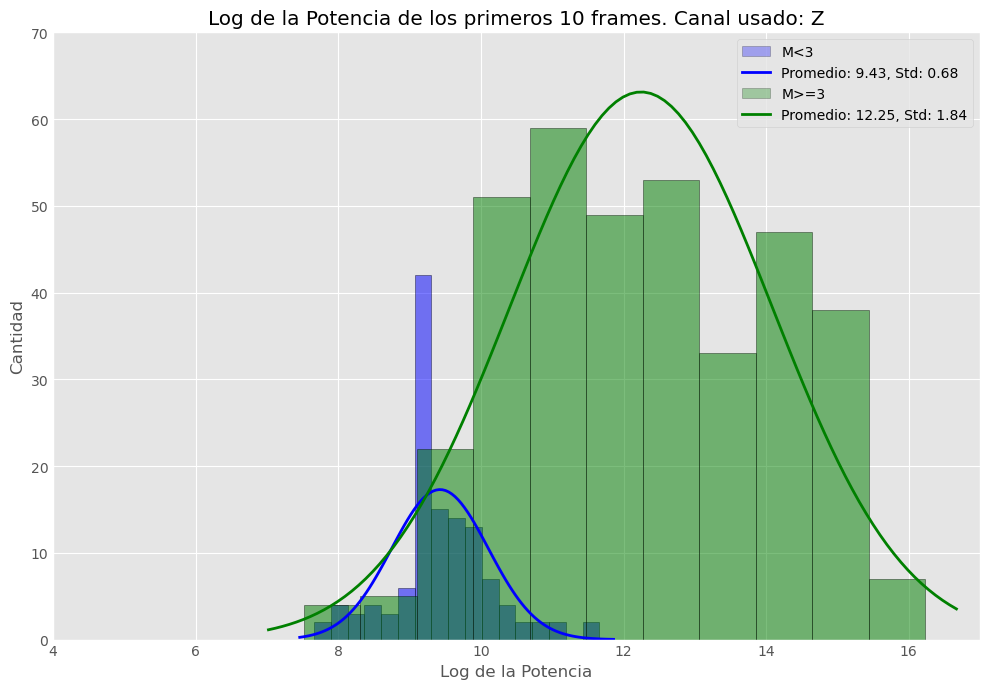

In [18]:
event_type = ['M<3','M>=3']
plot_power(power_sep_3_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [4,17],y_lim=70)

In [ ]:
event_type = ['M<4','M>=4']
plot_power(power_sep_4_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=70)

In [ ]:
event_type = ['M<5','M>=5']
plot_power(power_sep_5_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17],y_lim=70)

In [ ]:
event_type = ['M<6','M>=6']
plot_power(power_sep_6_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=70)

In [ ]:
event_type = ['M<3','M>=6']
plot_power([power_events_mag12_Z, power_events_mag69_Z], station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=45)

In [ ]:
event_type = ['M<4','M>=6']
plot_power([power_under_4_Z, power_events_mag69_Z], station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=60)

In [ ]:
event_type = ['M<3','M>=3','M>=4', 'M>=5', 'M>=6']
plot_power(power_all_mags_Z, station = '', channel = 'Z', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[4,17] ,y_lim=50)


## 4.2. Canal E

In [19]:
power_all_mags_E = [power_events_mag12_E, power_events_mag3_E, power_events_mag4_E, power_events_mag5_E, power_events_mag69_E]

power_over_3_E = list(itertools.chain(power_events_mag3_E, power_events_mag4_E, power_events_mag5_E, power_events_mag69_E))

power_over_4_E = list(itertools.chain(power_events_mag4_E, power_events_mag5_E, power_events_mag69_E))
power_under_4_E = list(itertools.chain(power_events_mag12_E, power_events_mag3_E))

power_over_5_E = list(itertools.chain(power_events_mag5_E, power_events_mag69_E))
power_under_5_E = list(itertools.chain(power_under_4_E, power_events_mag4_E))

power_under_6_E = list(itertools.chain(power_under_5_E, power_events_mag5_E))

power_sep_3_E = [power_events_mag12_E, power_over_3_E]
power_sep_4_E = [power_under_4_E, power_over_4_E]
power_sep_5_E = [power_under_5_E, power_over_5_E]
power_sep_6_E = [power_under_6_E, power_events_mag69_E]


In [ ]:
event_type = ['M<3','M>=3']
plot_power(power_sep_3_E, station = '', channel = 'E' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<4','M>=4']
plot_power(power_sep_4_E, station = '', channel = 'E', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<5','M>=5']
plot_power(power_sep_5_E, station = '', channel = 'E', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<6','M>=6']
plot_power(power_sep_6_E, station = '', channel = 'E', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=70)

In [ ]:
event_type = ['M<3','M>=6']
plot_power([power_events_mag12_E, power_events_mag69_E], station = '', channel = 'E', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=30)

In [ ]:
event_type = ['M<4','M>=6']
plot_power([power_under_4_E, power_events_mag69_E], station = '', channel = 'E' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=60)

In [ ]:
event_type = ['M<3','M>=3','M>=4', 'M>=5', 'M>=6']
plot_power(power_all_mags_E, station = '', channel = 'E' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=30)


## 4.3. Canal N

In [20]:
power_all_mags_N = [power_events_mag12_N, power_events_mag3_N, power_events_mag4_N, power_events_mag5_N, power_events_mag69_N]

power_over_3_N = list(itertools.chain(power_events_mag3_N, power_events_mag4_N, power_events_mag5_N, power_events_mag69_N))

power_over_4_N = list(itertools.chain(power_events_mag4_N, power_events_mag5_N, power_events_mag69_N))
power_under_4_N = list(itertools.chain(power_events_mag12_N, power_events_mag3_N))

power_over_5_N = list(itertools.chain(power_events_mag5_N, power_events_mag69_N))
power_under_5_N = list(itertools.chain(power_under_4_N, power_events_mag4_N))

power_under_6_N = list(itertools.chain(power_under_5_N, power_events_mag5_N))

power_sep_3_N = [power_events_mag12_N, power_over_3_N]
power_sep_4_N = [power_under_4_N, power_over_4_N]
power_sep_5_N = [power_under_5_N, power_over_5_N]
power_sep_6_N = [power_under_6_N, power_events_mag69_N]


In [ ]:
event_type = ['M<3','M>=3']
plot_power(power_sep_3_N, station = '', channel = 'N' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<4','M>=4']
plot_power(power_sep_4_N, station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<5','M>=5']
plot_power(power_sep_5_N, station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim= [20,35] ,y_lim=70)

In [ ]:
event_type = ['M<6','M>=6']
plot_power(power_sep_6_N, station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=70)

In [ ]:
event_type = ['M<3','M>=6']
plot_power([power_events_mag12_N, power_events_mag69_N], station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=30)

In [ ]:
event_type = ['M<4','M>=6']
plot_power([power_under_4_N, power_events_mag69_N], station = '', channel = 'N', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=60)

In [ ]:
event_type = ['M<3','M>=3','M>=4', 'M>=5', 'M>=6']
plot_power(power_all_mags_N, station = '', channel = 'N' ,n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=[20,35] ,y_lim=30)


# 5. Ver tiempo de inicio eventos mayores a 6

In [21]:
# calculate sta/lta algo for the whole trace_mag69_v2_Z list
trace_mag69_v2_Z = {k: v.trim(starttime=v.stats.starttime + 1, pad=True, fill_value=0) for k, v in trace_mag69_v2_Z.items()} # este código saca el primer segundo, esto ya que en el primer segundo hay como un pick extraño
trace_mag69_v2_Z_stream = [Stream(traces = trace) for trace in trace_mag69_v2_Z.values()]
sta_lta_mag6 = [p_picking_each(trace, ventana_10s = 10, ventana_30s = 30, nsta = 3, nlta = 13, thr_on = 4.2, thr_off = 1) for trace in trace_mag69_v2_Z_stream]

ic(len(trace_mag69_v2_Z_stream))
ic(len(sta_lta_mag6))


ic| len(trace_mag69_v2_Z_stream): 46
ic| len(sta_lta_mag6): 46


46

#### Hasta ahora problemáticos M>6:
- 4597528: Sin sta/lta, magnitud 7, mis ideas son que o la señal tiene mucho ruido o fue descargada la traza cuando ya había empezado el evento
- 5159022: Tres trigger, magnitud 8.3, llegada de diferentes ondas?
- 5159026: No hay trigger, pareceria haber mucho ruido
- 5159547: Se producen dos trigger, tendría sentido tomar el primero como onda P y el segundo como onda S??
- 10100470: Lo mismo de antes.
- 10997608: IDEM
- 11303695: IDEM

In [22]:
def analize_sta_lta(sta_lta: list, trace: dict, duration: float, off: bool = False):
    tr = list(trace.values())[0]
    key = list(trace.keys())[0]
    if sta_lta is not None:
        fig, ax = plt.subplots(figsize=(7, 3))
        ax.plot(tr.times(), tr.data, 'k')
        ax.set_title(f'Canal: {tr.stats.channel}. EventId: {key} ')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        #ax.set_xlim(0, 100)
        # add a vertical line where the cft array surpasses the threshold of 4.3
        ax.axvline(sta_lta - tr.stats.starttime ,  color='r', linestyle='--', label='ON')
        if off:
            ax.axvline(sta_lta - tr.stats.starttime + duration ,  color='b', linestyle='--', label='OFF')
        ax.legend()
        #plt.show()

    

In [23]:
# Obtener las ID y data de los eventos
keys = list(trace_mag69_v2_Z.keys())
values = list(trace_mag69_v2_Z.values())

sta_lta_mag6_clean = {}
count= 0
for i in range(len(sta_lta_mag6)):
    key = keys[i]
    value = values[i]
    if sta_lta_mag6[i]:
        count += 1
        sta_lta_mag6_clean[key] = sta_lta_mag6[i][0]
        analize_sta_lta(sta_lta_mag6[i][0], {key: value})
        
print(f'Se plotearon {count} eventos')

TypeError: analize_sta_lta() missing 1 required positional argument: 'duration'

ic| sta_lta_mag6[idx]: []
ic| tr_mag69_list[idx]: <obspy.core.trace.Trace object at 0x00000241AA47F880>


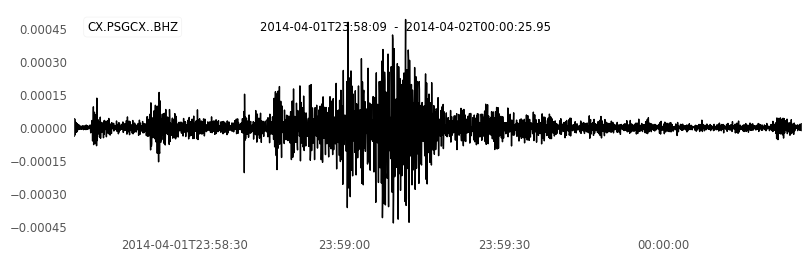

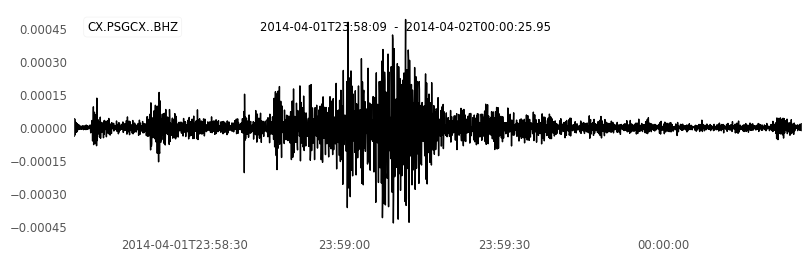

In [24]:
idx = 9
tr_mag69_list = list(trace_mag69_v2_Z.values())
ic(sta_lta_mag6[idx])
ic(tr_mag69_list[idx])
tr_mag69_list[idx].plot()

Los tiempos de incio quedaron guardados en el diccionario sta_lta_mag6_clean y en la lista . Esto en los casos donde las señales que son triggereadas por sta/lta. Hay 2 eventos que no fueron triggereados,


## 5.2. Cálculo del fin del evento.
Esto se hace considerando cuando la energía baja del 3% de su peak por frames

In [25]:
ic(len(sta_lta_mag6_clean))
ic(len(sta_lta_mag6))
ic(len(trace_mag69_v2_Z))
ic(len(trace_mag69_v2_Z_stream))

ic| len(sta_lta_mag6_clean): 1
ic| len(sta_lta_mag6): 46
ic| len(trace_mag69_v2_Z): 46
ic| len(trace_mag69_v2_Z_stream): 46


46

In [26]:
# Se calcula el punto donde cada traza tendría su finalización del evento
end_event = [endpoint_event(value.data, thr_energy = 0.97)[1] for value in values]
peak_enegy = [endpoint_event(value.data)[0] for value in values]

sliced_trs = []
duration = []
j = 0
k = []
for i in range(len(trace_mag69_v2_Z_stream)):
    if sta_lta_mag6[i]:
        sliced_trs.append(trace_mag69_v2_Z_stream[i].slice(starttime = sta_lta_mag6[i][0], endtime=sta_lta_mag6[i][0] + end_event[i]/40))
        duration.append(sliced_trs[j][0].stats.endtime - sliced_trs[j][0].stats.starttime)
        j += 1
    else:
        k.append(i)



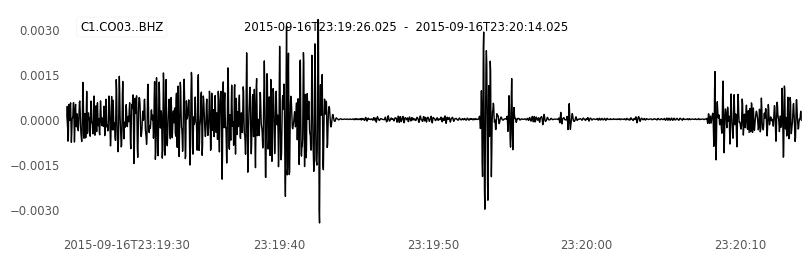

Start time: 2015-09-16T23:19:26.025000Z
End time: 2015-09-16T23:20:14.025000Z


In [27]:
# Se grafican las trazas cortadas
sliced_trs[12].plot()
print('Start time:', sliced_trs[12][0].stats.starttime)
print('End time:', sliced_trs[12][0].stats.endtime)

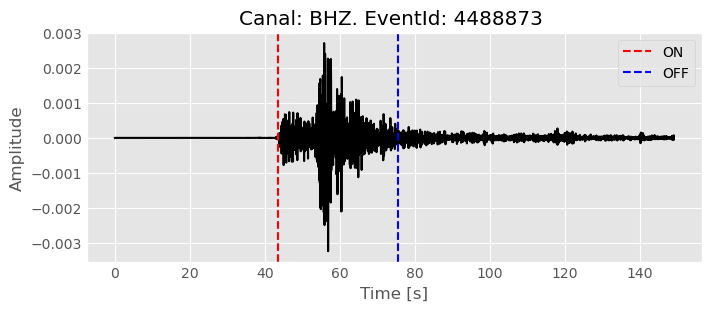

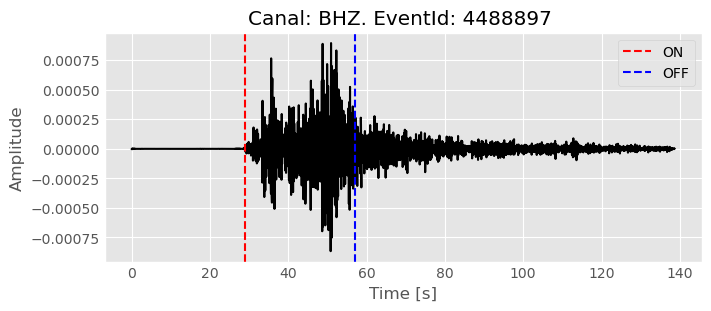

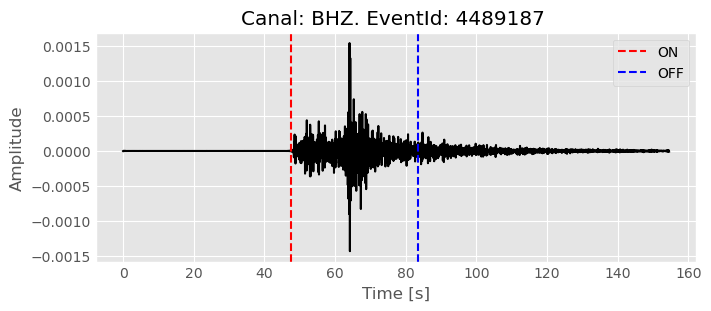

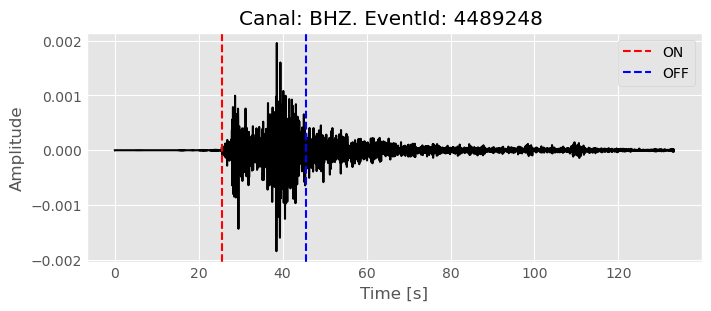

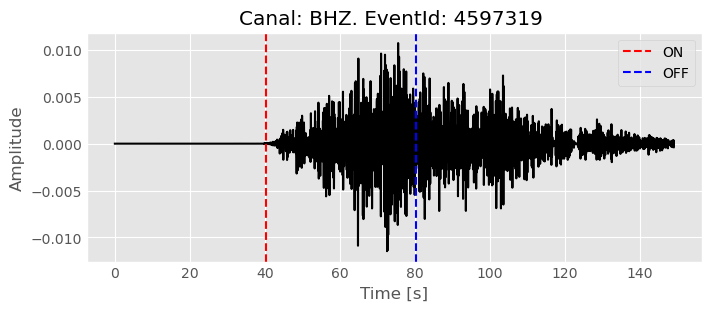

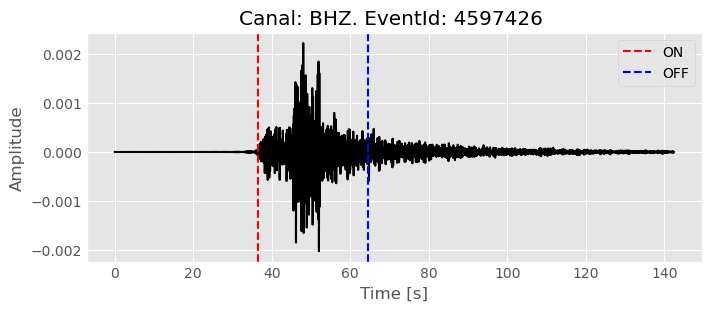

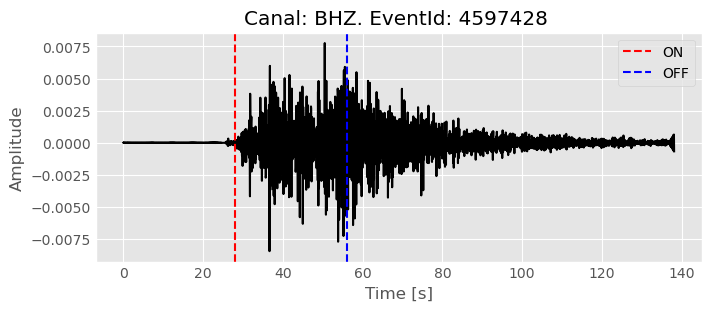

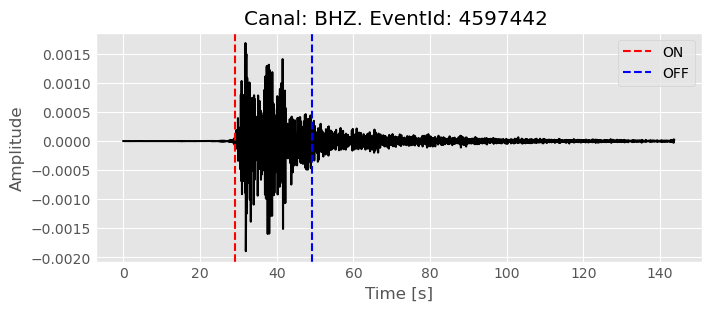

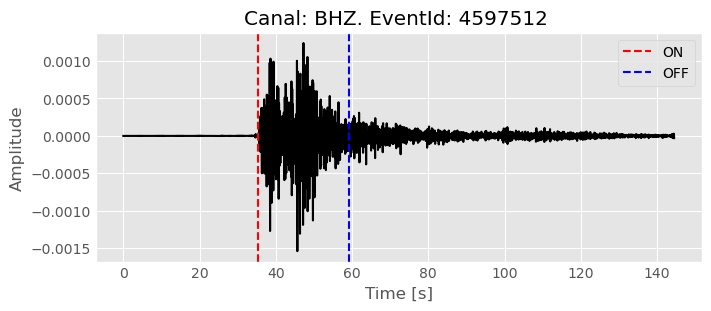

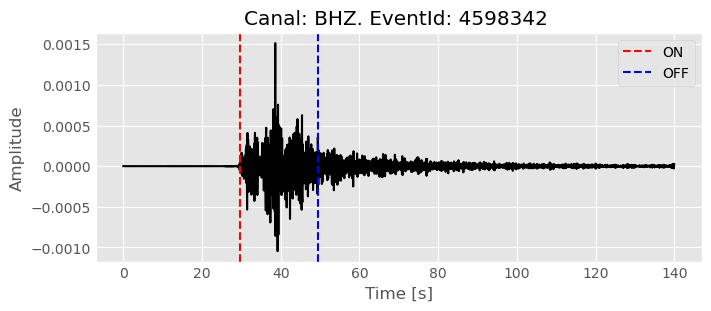

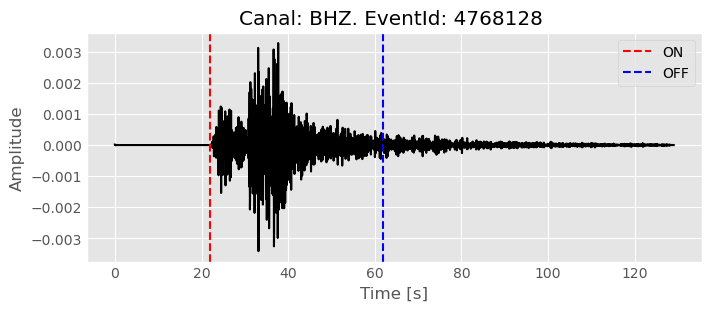

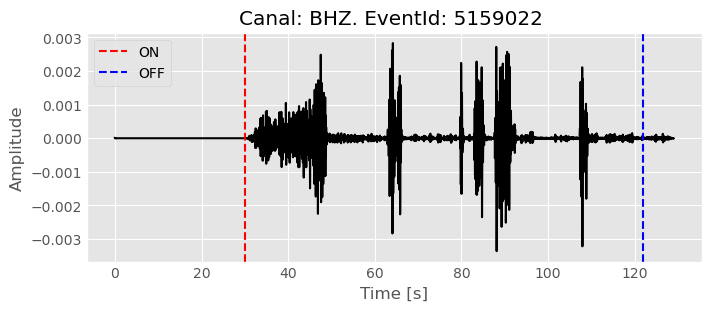

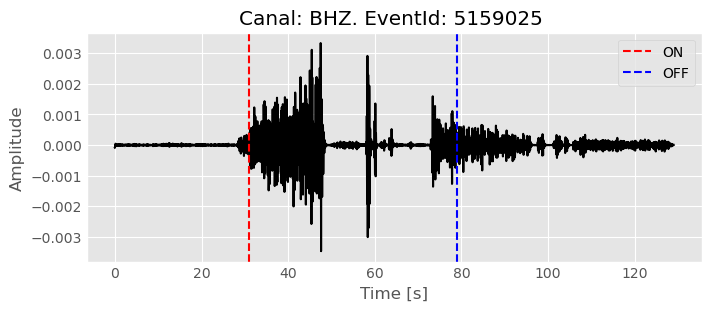

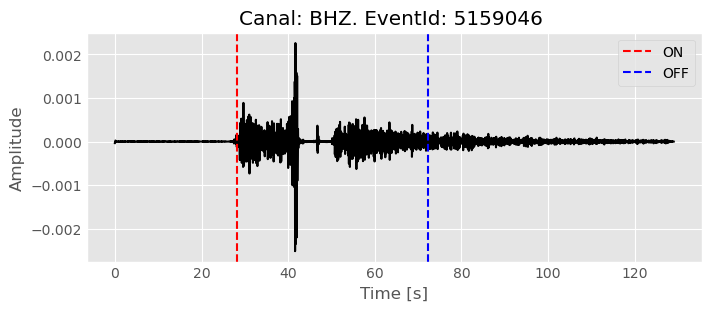

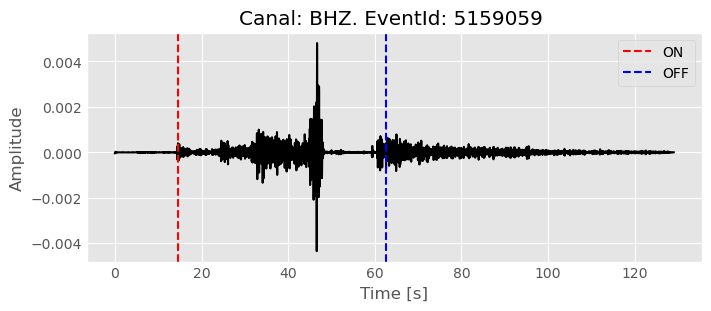

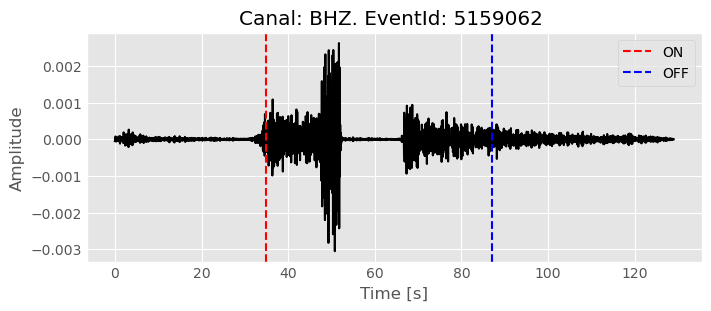

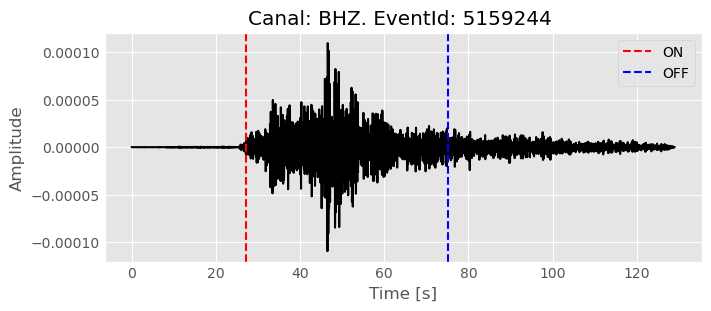

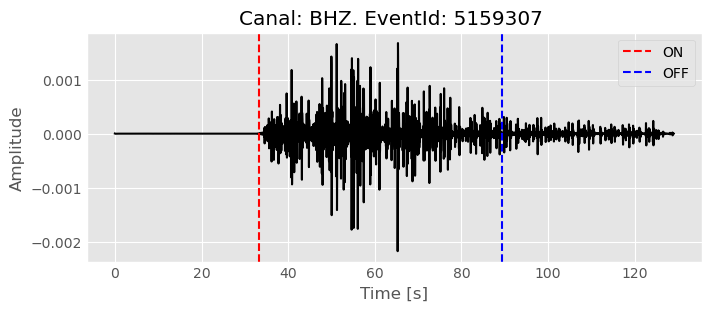

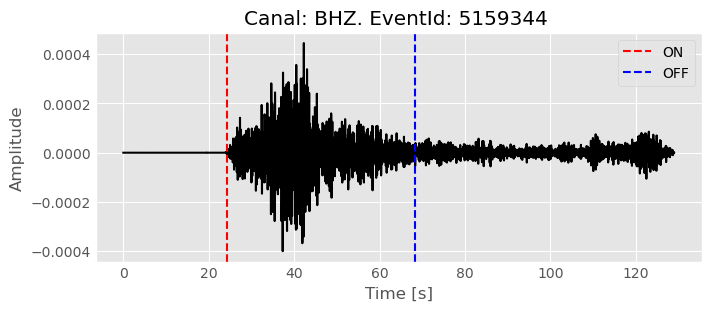

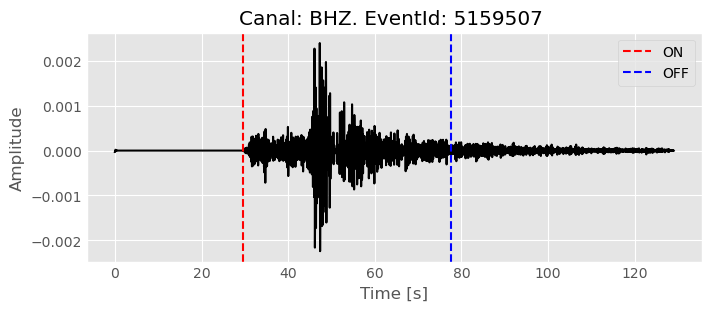

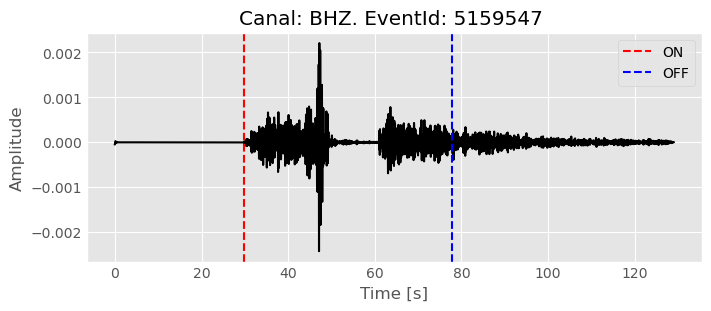

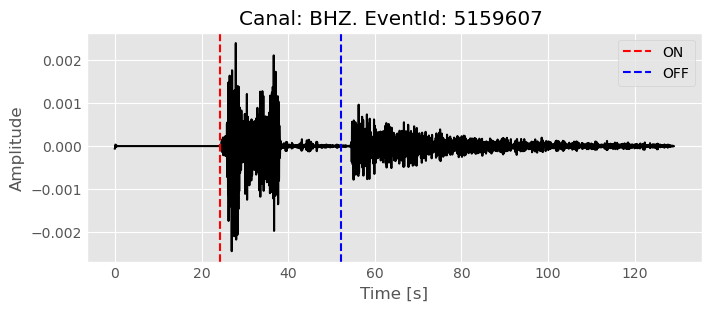

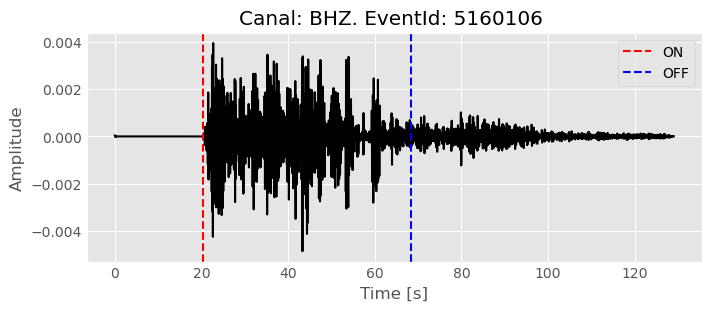

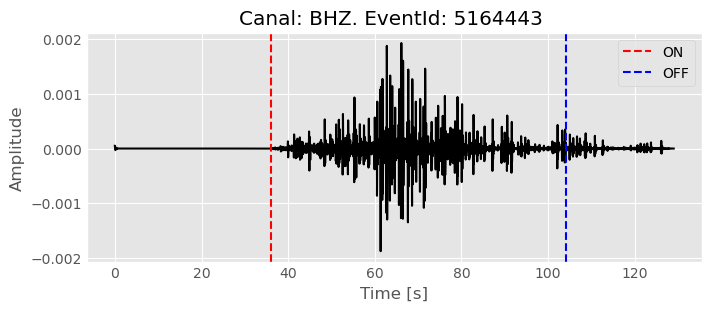

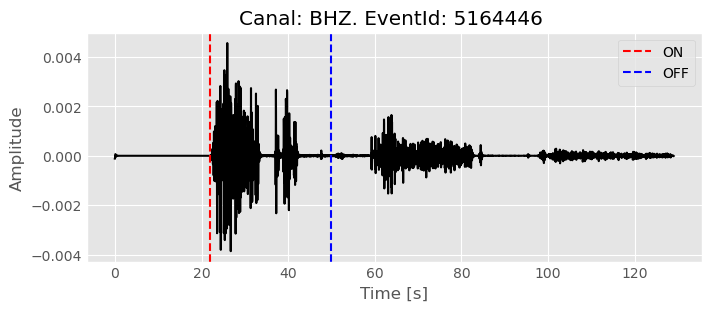

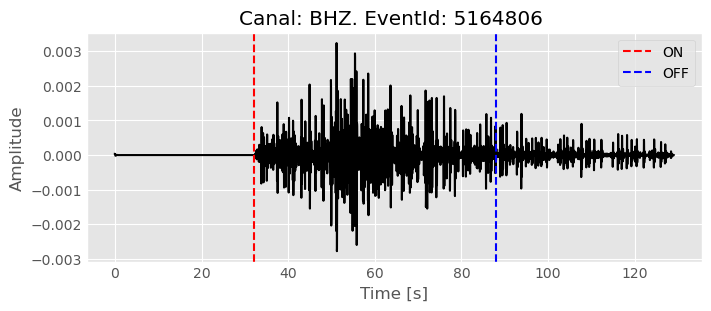

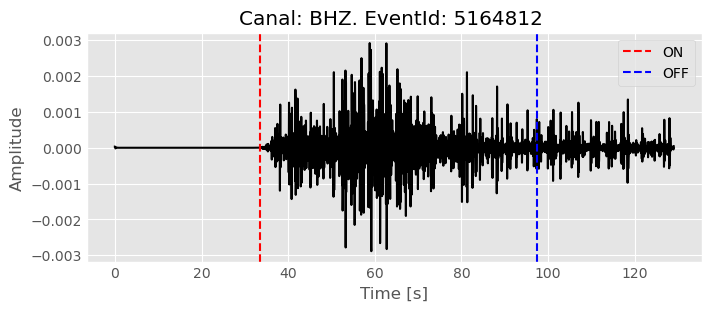

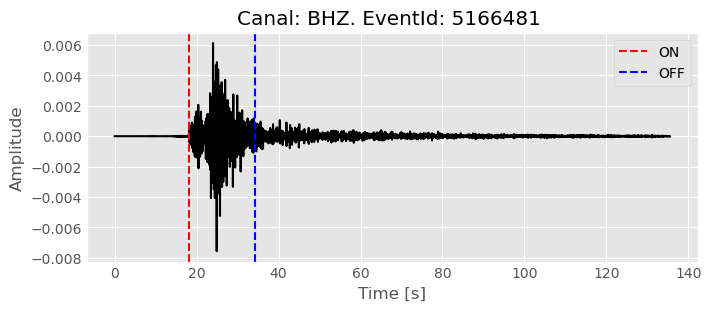

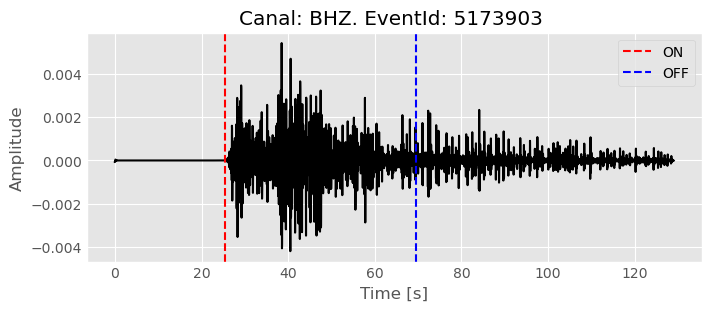

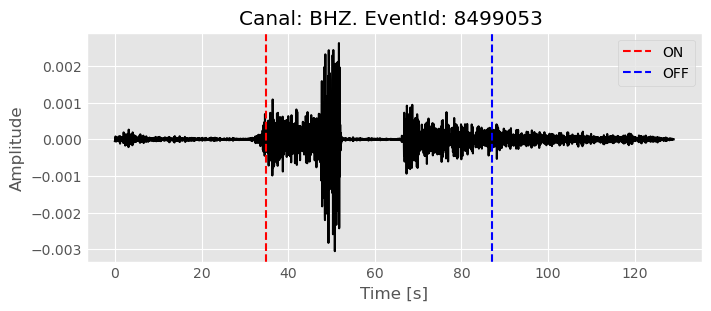

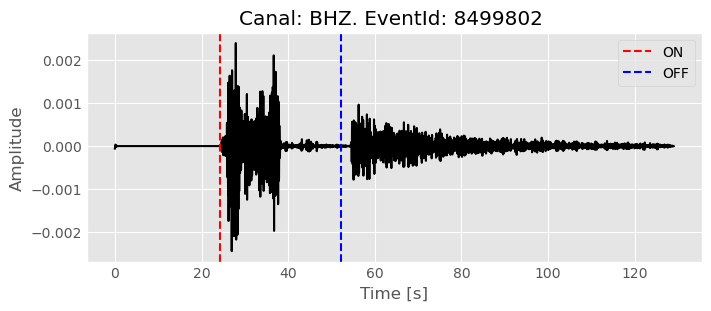

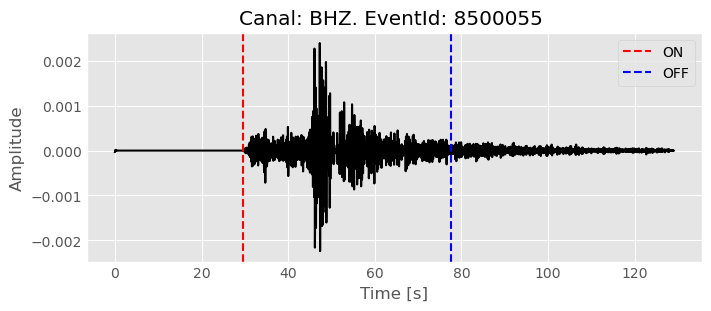

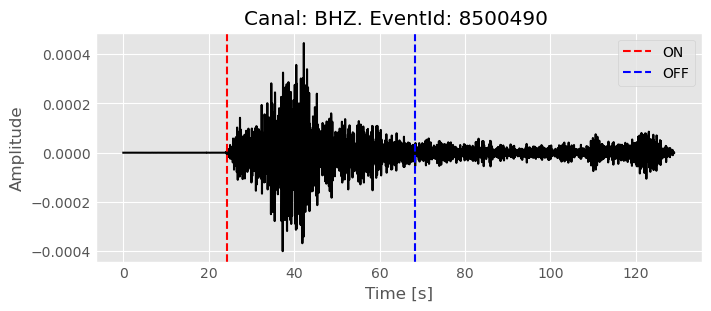

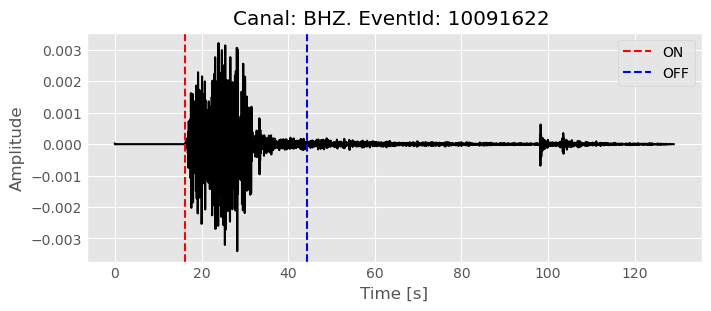

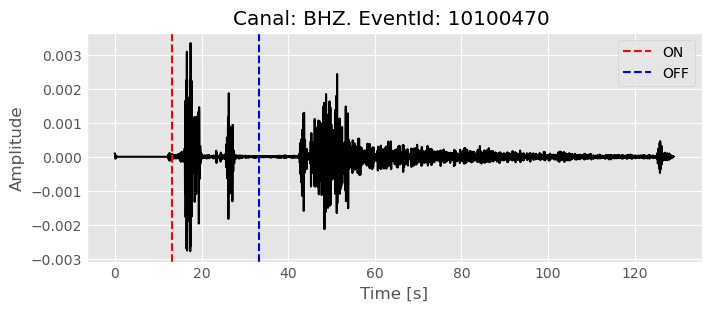

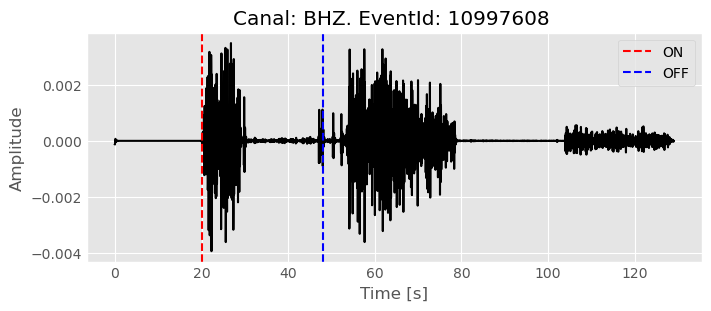

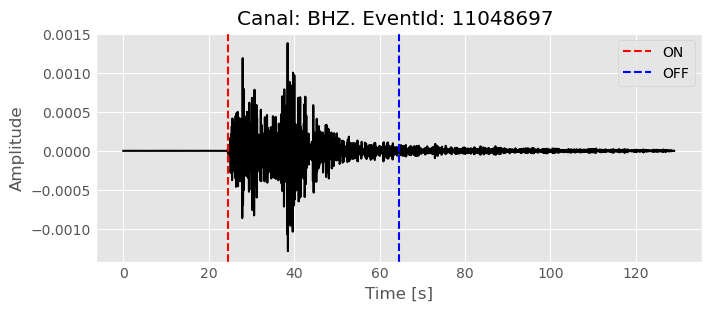

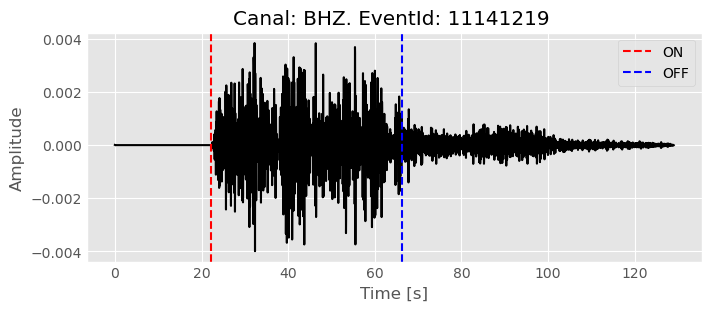

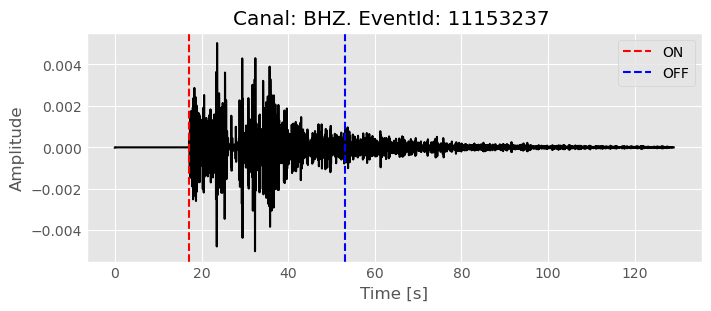

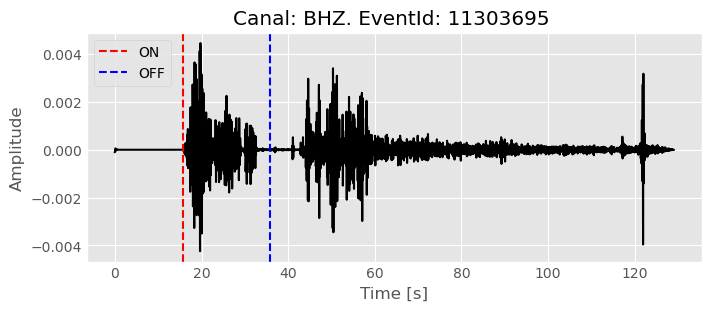

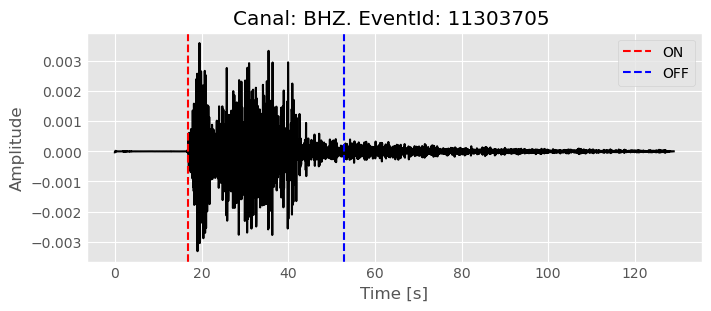

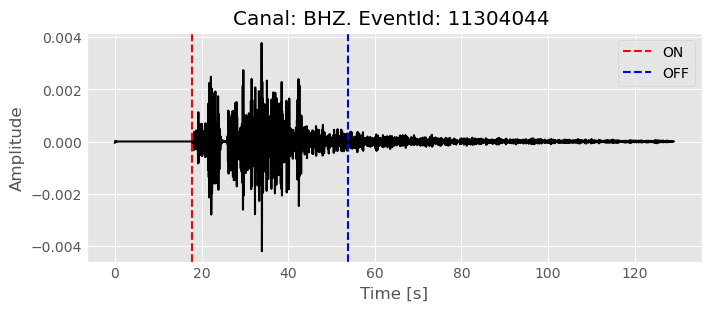

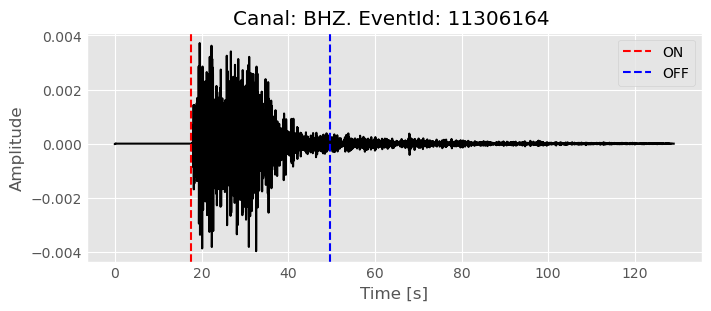

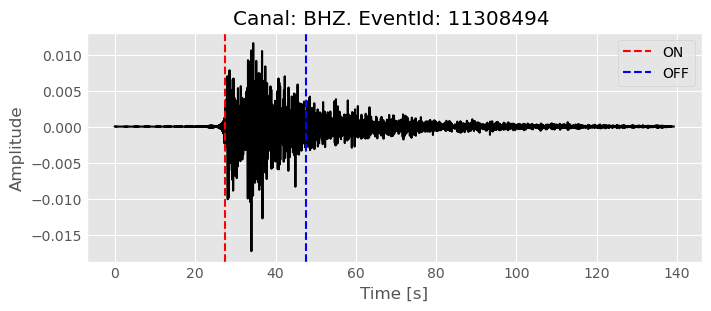

In [28]:
# Obtener las ID y data de los eventos
keys = list(trace_mag69_v2_Z.keys())
values = list(trace_mag69_v2_Z.values())

sta_lta_mag6_clean = {}
count= 0
j = 0
for i in range(len(sta_lta_mag6)):
    key = keys[i]
    value = values[i]
    if sta_lta_mag6[i]:
        count += 1
        sta_lta_mag6_clean[key] = sta_lta_mag6[i][0]
        analize_sta_lta(sta_lta_mag6[i][0], {key: value}, duration[j], off=True)
        j += 1
        


### Decaimiento del 3% del frame con la energía máxima 

In [29]:
dur = np.array(duration)
ic(np.mean(dur).round(2))
# calcula la desviacion estandar de dur
ic(np.std(dur).round(2))

ic| np.mean(dur).round(2): 38.82
ic| np.std(dur).round(2): 15.0


15.0

### Creación del excel

In [39]:
path_to_duration = os.path.join('BD paper', 'catalogos', 'duracion_eventos.xlsx')
# take the column "Duracion(s)" and calculate the mean and std
df_to_change = pd.read_excel(path_to_duration)



In [40]:
np.max(df_to_change['Duracion(s)'])

92

In [41]:
# Calculate the mean and standard deviation
mean_dur = np.mean(df_to_change['Duracion(s)']).round(2)
std_dur = round(np.std(df_to_change['Duracion(s)']),2)
max_dur = np.max(df_to_change['Duracion(s)'])
min_dur = np.min(df_to_change['Duracion(s)'])

# Add a new column 'Promedio' and 'Std' and set the first cell to the calculated values
df_to_change.at[0, 'Promedio'] = mean_dur
df_to_change.at[0, 'Sismo más largo'] = max_dur
df_to_change.at[0, 'Sismo más corto'] = min_dur
df_to_change.at[0, 'Std'] = std_dur

# Save the modified DataFrame back to an Excel file
df_to_change.to_excel(path_to_duration , index=False)


# 6. Gaussian Mixtures Models

ESto de abajo es un EJEMPLO GENÉRICO del uso de GMM de la librería sklearn

In [64]:
classes = ['M<3', 'M>=5']

power_all_mags_Z = [power_events_mag12_Z, power_events_mag3_Z, power_events_mag4_Z, power_events_mag5_Z, power_events_mag69_Z]


power_to_test_Z = [power_events_mag12_Z, power_events_mag5_Z ,power_events_mag69_Z]
power_last_frame_Z = [arr[-1] for tup in power_to_test_Z  for arr in tup]

X_z = np.array(power_last_frame_Z).reshape(-1,1)
X_z = np.log10(X_z)

y_z = np.concatenate([np.zeros(len(power_to_test_Z[0])),
                         np.ones(len(power_to_test_Z[1])),
                         np.ones(len(power_to_test_Z[2]))])

power_to_test_E = [power_events_mag12_E, power_events_mag5_E ,power_events_mag69_E]
power_last_frame_E = [arr[-1] for tup in power_to_test_E  for arr in tup]

X_e = np.array(power_last_frame_E).reshape(-1,1)
X_e = np.log10(X_e)

y_e = np.concatenate([np.zeros(len(power_to_test_E[0])),
                         np.ones(len(power_to_test_E[1])),
                         np.ones(len(power_to_test_E[2]))])

power_to_test_N = [power_events_mag12_N, power_events_mag5_N ,power_events_mag69_N]
power_last_frame_N = [arr[-1] for tup in power_to_test_N  for arr in tup]

X_n = np.array(power_last_frame_N).reshape(-1,1)
X_n = np.log10(X_n)

y_n = np.concatenate([np.zeros(len(power_to_test_N[0])),
                         np.ones(len(power_to_test_N[1])),
                         np.ones(len(power_to_test_N[2]))])


In [75]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
import scipy.stats as stats
# use seaborn plotting defaults
import seaborn as sns; sns.set()

rng = np.random.RandomState(42)

# Primero para el canal Z
X_train_Z, X_test_Z, y_train_Z, y_test_Z = train_test_split(X_z, y_z, test_size=0.3, random_state=rng)
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X_e, y_e, test_size=0.3, random_state=rng)
X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(X_n, y_n, test_size=0.3, random_state=rng)

# Crear un modelo GMM para cada canal
gmm_z = GaussianMixture(n_components=2, random_state=rng)
gmm_e = GaussianMixture(n_components=2, random_state=rng)
gmm_n = GaussianMixture(n_components=2, random_state=rng)

# Entrenar los modelos
gmm_z.fit(X_train_Z)
gmm_e.fit(X_train_E)
gmm_n.fit(X_train_N)

# Predecir las etiquetas para los datos
labels_z = gmm_z.predict(X_test_Z)
labels_e = gmm_e.predict(X_test_E)
labels_n = gmm_n.predict(X_test_N)

# Ordenar las etiquetas según la clase con más elementos
if np.sum(labels_z == 0) < np.sum(labels_z == 1):
    labels_z = 1 - labels_z

if np.sum(labels_e == 0) < np.sum(labels_e == 1):
    labels_e = 1 - labels_e

if np.sum(labels_n == 0) < np.sum(labels_n == 1):
    labels_n = 1 - labels_n

# Calcular la matriz de confusión
cm_Z = confusion_matrix(y_test_Z, labels_z)
cm_E = confusion_matrix(y_test_E, labels_e)
cm_N = confusion_matrix(y_test_N, labels_n)



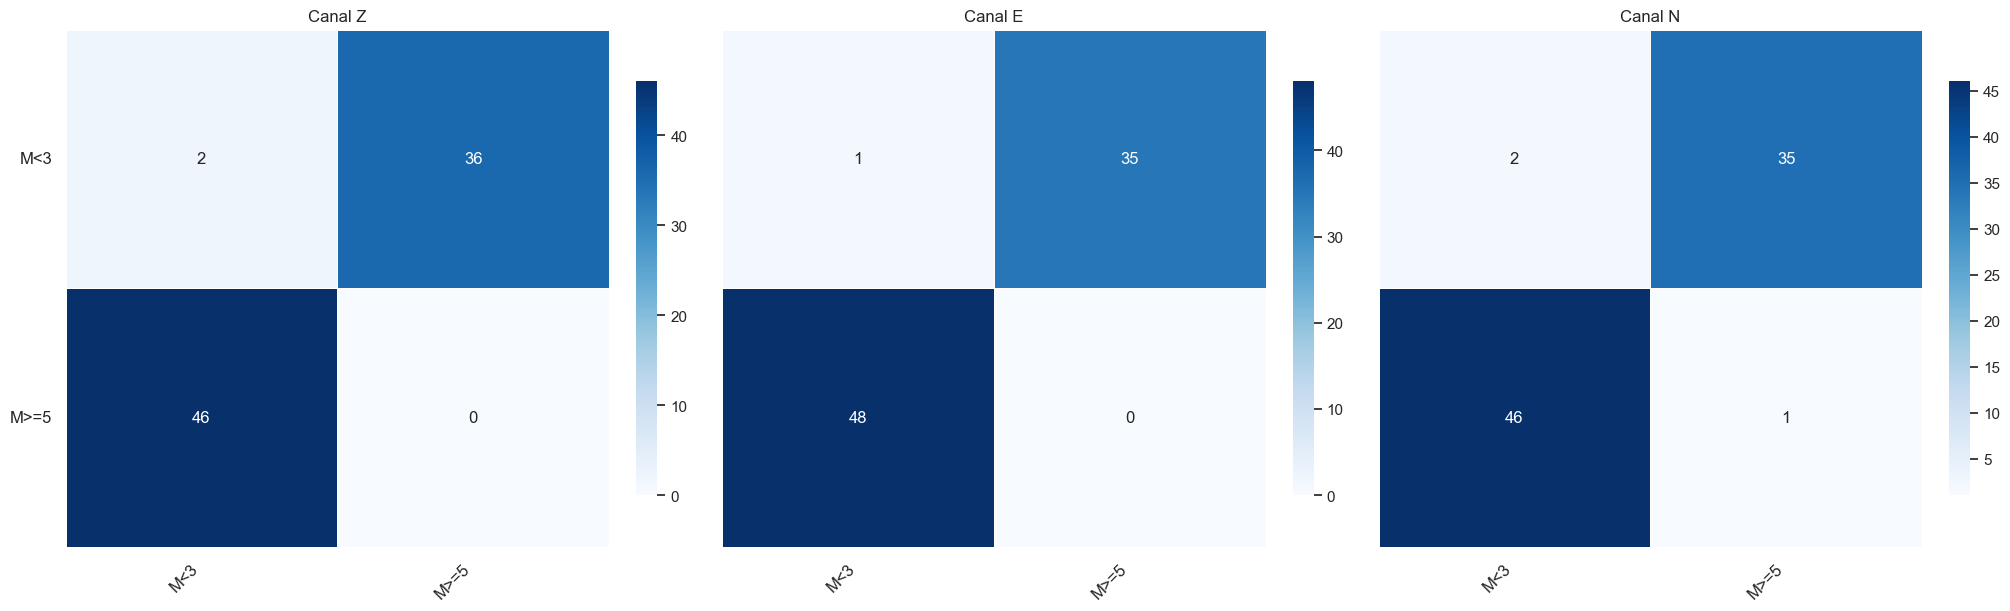

In [84]:
# Crear un mapa de calor de la matriz de confusión para el canal E
fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=False, gridspec_kw={'wspace': 0.05})

heatmap_z = sns.heatmap(cm_Z, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={"shrink": 0.8}, ax=ax[0])
heatmap_z.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_z.set_yticklabels(classes, rotation=0, fontsize=12)
ax[0].set_title('Canal Z')

# Crear un mapa de calor de la matriz de confusión para el canal E
heatmap_e = sns.heatmap(cm_E, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={"shrink": 0.8}, ax=ax[1])
heatmap_e.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_e.set_yticklabels([])  # Eliminar etiquetas del eje y
ax[1].set_title('Canal E')

# Crear un mapa de calor de la matriz de confusión para el canal N
heatmap_n = sns.heatmap(cm_N, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={"shrink": 0.8}, ax=ax[2])
heatmap_n.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_n.set_yticklabels([])  # Eliminar etiquetas del eje y
ax[2].set_title('Canal N')

# Ajustar el diseño para evitar superposiciones
plt.subplots_adjust(wspace=0.5)
plt.show()



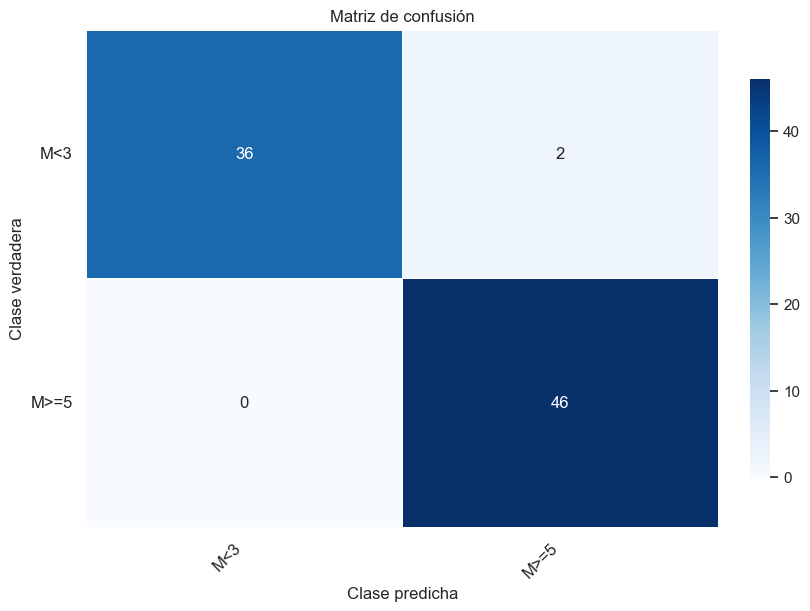

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir las clases
classes = ['M<3', 'M>=5']

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un mapa de calor de la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={"shrink": 0.8})

# Añadir etiquetas personalizadas al eje x e y
heatmap.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap.set_yticklabels(classes, rotation=0, fontsize=12)

plt.title('Matriz de confusión')
plt.xlabel('Clase predicha')
plt.ylabel('Clase verdadera')

plt.show()

In [ ]:
# Crear un mapa de calor de la matriz de confusión para el canal E
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

heatmap_z = sns.heatmap(cm_Z, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={"shrink": 0.8}, ax=ax[0])
heatmap_z.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_z.set_yticklabels(classes, rotation=0, fontsize=12)
ax[0].set_title('Matriz de confusión - Canal Z')
ax[0].set_xlabel('Clase predicha')
ax[0].set_ylabel('Clase verdadera')

# Crear un mapa de calor de la matriz de confusión para el canal E
heatmap_e = sns.heatmap(cm_E, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={"shrink": 0.8}, ax=ax[1])
heatmap_e.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_e.set_yticklabels(classes, rotation=0, fontsize=12)
ax[1].set_title('Canal E - Matriz de confusión')
ax[1].set_xlabel('Clase predicha')
ax[1].set_ylabel('Clase verdadera')

# Crear un mapa de calor de la matriz de confusión para el canal N
heatmap_n = sns.heatmap(cm_N, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar_kws={"shrink": 0.8}, ax=ax[2])
heatmap_n.set_xticklabels(classes, rotation=45, ha='right', fontsize=12)
heatmap_n.set_yticklabels(classes, rotation=0, fontsize=12)
ax[2].set_title('Canal N - Matriz de confusión')
ax[2].set_xlabel('Clase predicha')
ax[2].set_ylabel('Clase verdadera')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()


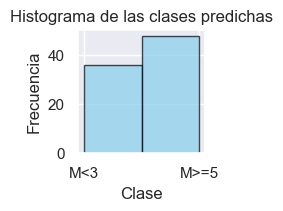

In [48]:
# Crear un histograma de las clases predichas
plt.hist(y_pred, bins=2, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Histograma de las clases predichas')
plt.xlabel('Clase')
plt.xticks([0,1], classes)
plt.ylabel('Frecuencia')
plt.show()


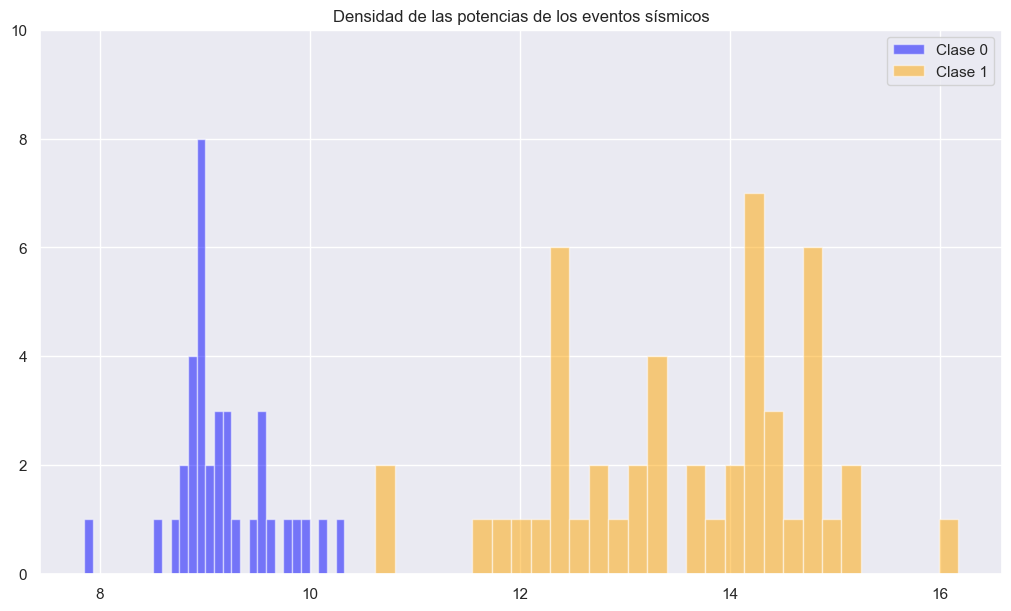

In [50]:

# Crear un gráfico de densidad de las potencias de los eventos sísmicos
plt.figure(figsize=(10,6))
plt.title('Densidad de las potencias de los eventos sísmicos')
colors = ['blue', 'orange']  # Definir los colores para cada clase
for i in range(2):
    mask = (y_pred == i)  # Crear una máscara booleana
    subset = X_test[mask]  # Aplicar la máscara a X_test
    subset = np.squeeze(subset)  # Eliminar las dimensiones de tamaño uno
    if len(subset) > 0:
        plt.hist(subset, bins=30, density=False, alpha=0.5, color=colors[i], label=f'Clase {i}')
plt.legend()
plt.ylim([0, 10])  # Cambiar la escala del eje y    
plt.show()

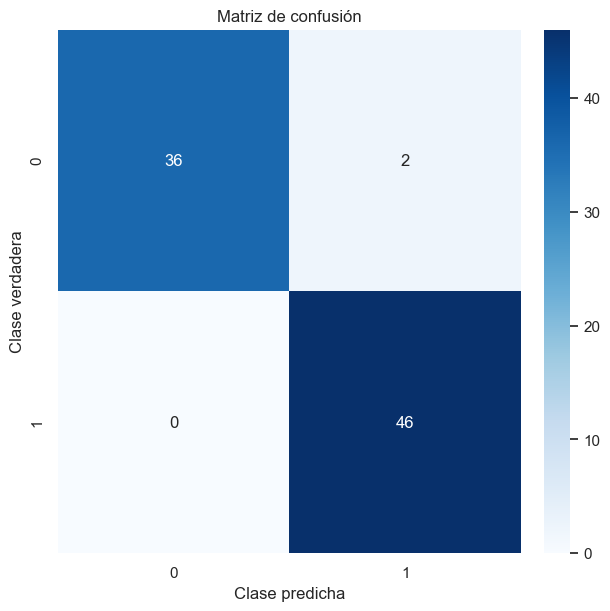

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Clase predicha')
plt.ylabel('Clase verdadera')
plt.show()

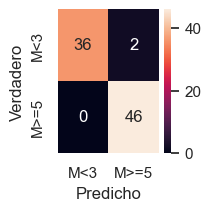

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()



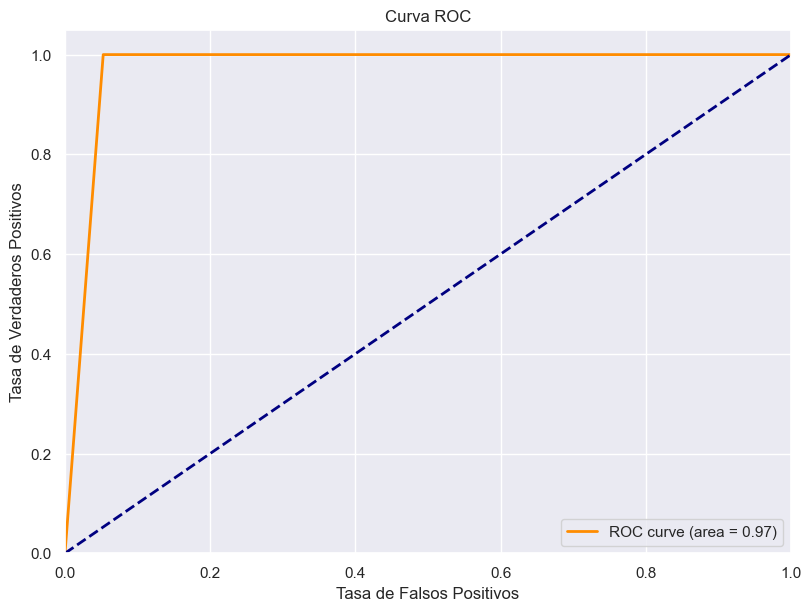

In [54]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
